# Projeto Machine Learning II

> Liliane Lourença de Aquino

## Imports necessários

In [30]:
"""
    Bibliotecas básicas de DS
"""
import warnings
import numpy as np
import pandas as pd
from typing import List

"""
    Bibliotecas básicas de estatística
"""
from scipy.stats import chi2_contingency

"""
    Bibliotecas de visualização de dados
"""
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
%matplotlib inline

"""
 Bibliotecas para análise do dataset
"""
import sidetable

"""
 Biblioteca de ML
"""
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

## Aprendizado supervisionado: modelo de crédito

> Objetivo: desenvolver um modelo capaz de classificar a pontuação de crédito de um cliente (poor, standard ou good).

### Dicionário dos dados

|Campos|Descrição|
|---|---|
| ID | identificador para cada registro |
| Customer_ID | identificador para cada cliente |
| Mês | mês de registro das informações |
| Nome | nome |
| Idade | idade |
| SSN | número de Segurança Social |
| Ocupação | ocupação ou cargo |
| Annual_Income | renda anual |
| Monthly_Inhand_Salary | quantia em dinheiro que o cliente recebe como salário mensalmente |
| Num_Bank_Accounts | número de contas bancárias que o cliente possui |
| Num_Credit_Card | número de cartões de crédito que o cliente possui |
| Interest_Rate | taxa de juros associada a algum produto financeiro |
| Num_of_Loan | número de empréstimos que o cliente possui |
| Type_of_Loan | tipo de empréstimo(s) que o cliente possui |
| Delay_from_due_date | período de atraso nos pagamentos a partir da data de vencimento |
| Num_of_Delayed_Payment | número de pagamentos atrasados |
| Changed_Credit_Limit | indica se houve alteração no limite de crédito |
| Num_Credit_Inquiries | quantidade de consultas de crédito realizadas pelo cliente |
| Credit_Mix | combinação de diferentes tipos de contas de crédito |
| Outstanding_Debt | valor da dívida pendente |
| Credit_Utilization_Ratio | relação entre o crédito utilizado e o limite de crédito total |
| Credit_History_Age | tempo desde que o cliente começou a construir seu histórico de crédito |
| Payment_of_Min_Amount | comportamento de pagamento em relação aos pagamentos mínimos exigidos |
| Total_EMI_per_month | total de pagamentos de Parcela Mensal Equacionada (EMI) feitos pelo cliente (método de pagamento comum para empréstimos) |
| Amount_invested_monthly | valor que o cliente investe mensalmente |
| Payment_Behaviour | comportamento relacionado a pagamentos |
| Monthly_Balance | saldo mensal do cliente em suas contas financeiras |
| Credit_Score | pontuação de crédito associada à qualidade de crédito do cliente |


### Conjunto de dados

In [2]:
df = pd.read_csv('data/train.csv')
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head(1)

Linhas: 100000 | Colunas: 28


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.82262,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good


### Elimina clientes duplicados

In [3]:
df.drop_duplicates(subset=['Customer_ID'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')

Linhas: 12500 | Colunas: 28


### Informação dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        12500 non-null  object 
 1   Customer_ID               12500 non-null  object 
 2   Month                     12500 non-null  object 
 3   Name                      11273 non-null  object 
 4   Age                       12500 non-null  object 
 5   SSN                       12500 non-null  object 
 6   Occupation                12500 non-null  object 
 7   Annual_Income             12500 non-null  object 
 8   Monthly_Inhand_Salary     10639 non-null  float64
 9   Num_Bank_Accounts         12500 non-null  int64  
 10  Num_Credit_Card           12500 non-null  int64  
 11  Interest_Rate             12500 non-null  int64  
 12  Num_of_Loan               12500 non-null  object 
 13  Type_of_Loan              11074 non-null  object 
 14  Delay_

### Seleção de features

In [5]:
df.drop(['ID', 'Name', 'Age', 'SSN', 'Month', 'Customer_ID'], axis=1, inplace=True)

<p style='text-align: justify;'><font size=3.>Considerando que para definir a pontuação de crédito as informações mais relevantes são as financeiras e de pagamento, foram removidas da base as colunas que identificam o cliente de forma pessoal e aquelas que não agregam informação.</font></p>

### Correção dos tipos

In [6]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce', downcast='integer')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce', downcast='float')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce', downcast='float')

### Valores nulos

In [7]:
df.stb.missing()

,missing,total,percent
Monthly_Inhand_Salary,1861,12500,14.888
Type_of_Loan,1426,12500,11.408
Num_of_Delayed_Payment,1175,12500,9.400
Amount_invested_monthly,1114,12500,8.912
Credit_History_Age,1113,12500,8.904
Num_Credit_Inquiries,236,12500,1.888
Monthly_Balance,134,12500,1.072
Outstanding_Debt,0,12500,0.000
Payment_Behaviour,0,12500,0.000
Total_EMI_per_month,0,12500,0.000


In [8]:
for col in ['Type_of_Loan', 'Credit_History_Age']:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [9]:
for col in ['Monthly_Inhand_Salary',
            'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Num_Credit_Inquiries', 'Monthly_Balance']:
    df[col].interpolate(method='linear', inplace=True, limit_direction='both')

<p style='text-align: justify;'><font size=3>Para tratar os valores nulos numéricos, optaremos por preenchê-los usando a técnica de interpolação linear, que permite o preenchimento com valores intermediários usando como base os seus vizinhos e para os categóricos, usaremos a moda. Isso irá previnir a perda de uma quantidade significativa de dados valiosos.</font></p>

### Limpeza dos dados categóricos

In [10]:
df.loc[df['Credit_Mix'] == '_', 'Credit_Mix'] = 'Desconhecido'
df.loc[df['Occupation'] == '_______', 'Occupation'] = 'Desconhecido'
df.loc[df['Changed_Credit_Limit'] == '_', 'Changed_Credit_Limit'] = 'Desconhecido'
df.loc[df['Payment_Behaviour'] == '!@9#%8', 'Payment_Behaviour'] = 'Desconhecido'

df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('-', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)

df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '').astype(float)
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '').astype(float)
df['Delay_from_due_date'] = df['Delay_from_due_date'].abs()
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].abs()

### Engenharia de recurso

In [11]:
def ageToMonths(creditHistoryAge: str) -> int:
    parts = creditHistoryAge.split(' Years and ')

    years = int(parts[0])
    months = int(parts[1].split(' Months')[0])
    return years * 12 + months

df['Credit_History_Month'] = df['Credit_History_Age'].apply(ageToMonths)

In [12]:
allLoanTypes: List[str] = []

for entry in df['Type_of_Loan']:
    loanTypes = [typeOfLoan.strip() for typeOfLoan in entry.split(',')]
    allLoanTypes.extend(loanTypes)

allLoanTypes = [loan.replace('and ', '') for loan in allLoanTypes]
allLoanTypes = list(set(allLoanTypes))
allLoanTypes.remove('Not Specified')

for loanType in allLoanTypes:
    df[loanType] = df['Type_of_Loan'].apply(lambda x: 'S' if loanType in x else 'N')

In [13]:
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].apply(lambda x: 'Desconhecido' if x == '-' or x == 'Desconhecido' else ('N' if float(x) < 0 else 'S'))

In [14]:
df.drop(['Credit_History_Age', 'Type_of_Loan'], axis=1, inplace=True)

<p style='text-align: justify;'><font size=3.>Algumas colunas foram usadas para gerar outras informações em formato mais relevante para o modelo. Para reduzir a alta cardinalidade, para os tipos de empréstimos vamos considerar se o cliente teve ou não determinado tipo de empréstimo. Para a coluna Changed_Credit_Limit, vamos considerar apenas se houve ou não mudança, porque os valores estão estranhos na base.</font></p>

### Base final

In [15]:
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head()

Linhas: 12500 | Colunas: 29


,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Month,Credit-Builder Loan,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Auto Loan,Personal Loan,Payday Loan,Student Loan
0,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,S,4.0,Desconhecido,809.98,26.822620,No,49.574949,80.415298,High_spent_Small_value_payments,312.494080,Good,265,S,N,N,S,S,S,N,N
1,Desconhecido,34847.84,3037.986667,2,4,6,1,3,4.0,S,2.0,Good,605.03,24.464031,No,18.816215,104.291824,Low_spent_Small_value_payments,470.690613,Standard,319,S,N,N,N,N,N,N,N
2,Desconhecido,143162.64,12187.220000,1,5,8,3,5,8.0,S,3.0,Good,1303.01,28.616735,No,246.992319,168.413696,Desconhecido,1043.315918,Good,213,N,N,N,N,S,N,N,N
3,Entrepreneur,30689.89,2612.490833,2,5,4,1,0,6.0,S,4.0,Good,632.46,26.544229,No,16.415452,81.228859,Low_spent_Large_value_payments,433.604767,Standard,207,N,N,N,N,N,N,N,N
4,Developer,35547.71,2853.309167,7,5,5,0,5,8.0,S,4.0,Standard,943.86,39.797764,Yes,0.000000,276.725403,Desconhecido,288.605530,Standard,368,N,N,N,N,N,N,N,N


### Perfil médio dos clientes

In [16]:
df[['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card','Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment']].describe().round(2)

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment
count,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00
mean,188861.70,4210.79,17.28,21.65,69.47,11.32,21.08,32.46
std,1482707.01,3093.55,118.52,123.79,455.96,64.46,14.83,229.29
min,7005.93,303.65,0.00,1.00,1.00,0.00,0.00,0.00
25%,19487.77,1693.99,3.00,4.00,8.00,2.00,10.00,9.00
50%,37655.08,3197.00,6.00,5.00,13.00,3.00,18.00,14.00
75%,72898.13,5923.98,7.00,7.00,20.00,6.00,28.00,18.00
max,23658189.00,15204.63,1779.00,1479.00,5788.00,1496.00,67.00,4388.00


<p style='text-align: justify;'><font size=3.>A renda média anual desses clientes é relativamente alta e a diferença entre os valores mínimo e máximo na base sugerem a presença de alguns valores extremos. A média e a mediana do salário mensal indicam que esses clientes é relativamente bem remunerados, porém percebemos variação significativa nos salários mensais. A média do número de contas bancárias por cliente é moderada, mas o desvio padrão é bem alto sugerindo uma grande variação. Os clientes possuem, em média, 22 cartões de crédito e o desvio padrão é bem alto, indicando diferenças no comportamento financeiro dessas pessoas.</font></p>

<p style='text-align: justify;'><font size=3.>A média da taxa de juros é de 69.47 e alta variação pode está relacionada aos diferentes produtos associados. Pela média de 11,32, podemos perceber que alguns clientes possuem múltiplos empréstimos. A média de atraso de pagamentos é alta, assim como a média do número de pagamentos atrasados indicando que nessa base temos clientes com um histórico de pagamento com algum grau de atraso.</font></p>

In [17]:
df[['Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Month']].describe().round(2)

,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Month
count,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00,12500.00
mean,24.51,1426.22,32.29,1303.78,192.05,405.70,214.69
std,182.23,1155.17,5.08,8118.26,189.17,217.58,95.55
min,0.00,0.23,20.99,0.00,0.00,0.09,1.00
25%,2.00,566.07,28.11,29.13,73.92,271.94,150.50
50%,4.00,1166.16,32.30,66.37,129.03,337.50,205.00
75%,8.00,1945.96,36.46,149.90,233.79,475.11,289.00
max,2592.00,4998.07,49.56,82122.00,1706.88,1602.04,397.00


<p style='text-align: justify;'><font size=3.>Em relação ao número de consultas de crédito temos uma média relativamente alta com uma grande variação evidenciada pelo desvio padrão elevado. Os clientes têm, em média, uma quantidade razoável de dívida com um valor de R\$ 1426,22 e uma variação de R\$ 1155,17. Em relação à  taxa de utilização de crédito, pela média, percebemos que os clientes utilizaram cerca de 32% do seu limite total. A média dos pagamentos mensais do EMI dos clientes é de R\$ 1303,78 e a variação muito alta indica uma ampla faixa de valores na base.</font></p>

<p style='text-align: justify;'><font size=3.>A média do valor investido mensalmente é de R\$ 192,05 o que sugere que os clientes investem uma baixa quantia mensalmente. A média do saldo mensal nas contas e a sua variação são relativamente baixos e o histórico médio dos clientes é de, aproximadamente, 18 anos podendo variar até 96 meses para mais ou menos.</font></p>

In [18]:
df.describe(include='O')

,Occupation,Changed_Credit_Limit,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,Credit-Builder Loan,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Auto Loan,Personal Loan,Payday Loan,Student Loan
count,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500,12500
unique,16,3,4,3,7,3,2,2,2,2,2,2,2,2
top,Desconhecido,S,Standard,Yes,Low_spent_Small_value_payments,Standard,N,N,N,N,N,N,N,N
freq,827,12073,4564,6524,3118,6943,8534,8620,8580,8575,8680,8612,8507,8620


<p style='text-align: justify;'><font size=3.>Para  boa parte dos clientes do banco não temos o tipo de profissão. A maioria dos clientes teve ajustes nos limites de crédito, tem um mix de crédito classificado como Standard, realiza o pagamento mínimo e têm um comportamento de gasto relativamente baixo com pagamentos de pequenos valores. A pontuação de crédito mais frequente é a Standard e muito deles não possuem diferentes tipos de empréstimos.</font></p>

### Distribuição da variável alvo 

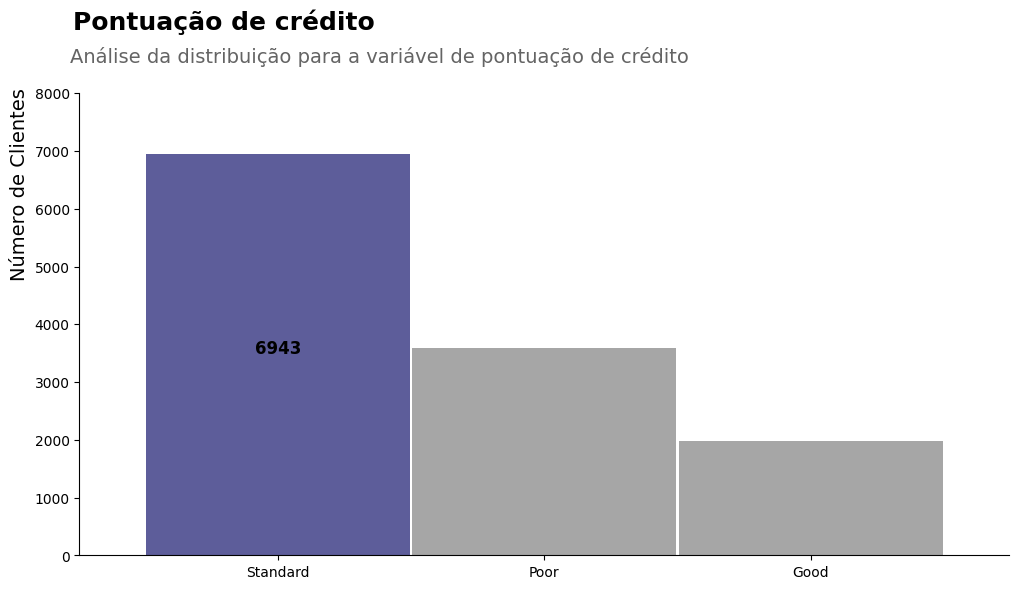

In [19]:
suptitle = 'Pontuação de crédito'
title = 'Análise da distribuição para a variável de pontuação de crédito'
colors=['#191970', '#808080', '#808080']

creditScore = df['Credit_Score'].value_counts()
creditScore.plot.bar(width=0.99, alpha=0.7, figsize=(12, 6), rot=False, color=colors).spines[['top', 'right']].set_visible(False)

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel(None)
plt.ylabel('Número de Clientes', fontsize=14, horizontalalignment='left', y=0.595)
plt.text(0, 3500, '6943', fontsize=12, weight='bold', horizontalalignment='center')
plt.ylim(0, 8000)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Como já tinhamos visto, boa parte dos clientes do banco possui a pontuação de crédito classificada como Standard, com esse grupo ocupando 56% da base de clientes. É possível notar um desequilíbrio significativo entre esses grupos o que pode ser um desafio na hora de desenvolver modelos de aprendizagem de máquina, uma vez que modelos treinados em dados desequilibrados podem ser tendenciosos em direção à classe majoritária.</font></p>

### Análise renda mensal

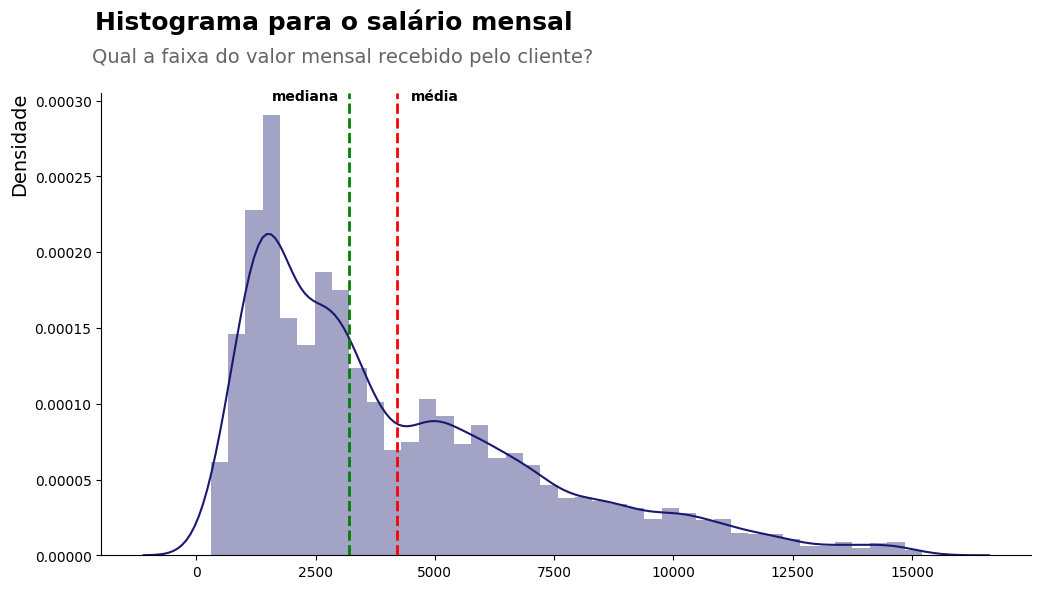

In [20]:
suptitle = 'Histograma para o salário mensal'
title = 'Qual a faixa do valor mensal recebido pelo cliente?'

ax = sns.distplot(df['Monthly_Inhand_Salary'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.779)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)

plt.axvline(x=4210.79, color='r', linestyle='dashed', linewidth=2, label='Média')
plt.text(5000, 0.00030, 'média', fontsize=10, weight='bold', horizontalalignment='center')

plt.axvline(x=3196.99, color='g', linestyle='dashed', linewidth=2, label='Mediana')
plt.text(2300, 0.00030, 'mediana', fontsize=10, weight='bold', horizontalalignment='center')

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>O histograma é assimétrico e é possível perceber uma alta concentração na faixa de valores salariais mais baixos e também alguns valores muito mais altos. A média salarial é de, aproximadamente, R\$ 4210,79 com um desvio de R\$ 3093,55 o que indica uma dispersão substancial dos salários, sugerindo que temos alguns significativamente mais altos ou mais baixos do que a média. Além disso, a mediana de R\$ 3196,99 é menor o que também sugere que existem alguns valores mais altos no conjunto de dados que estão influenciando a média.</font></p>

### Ocupação

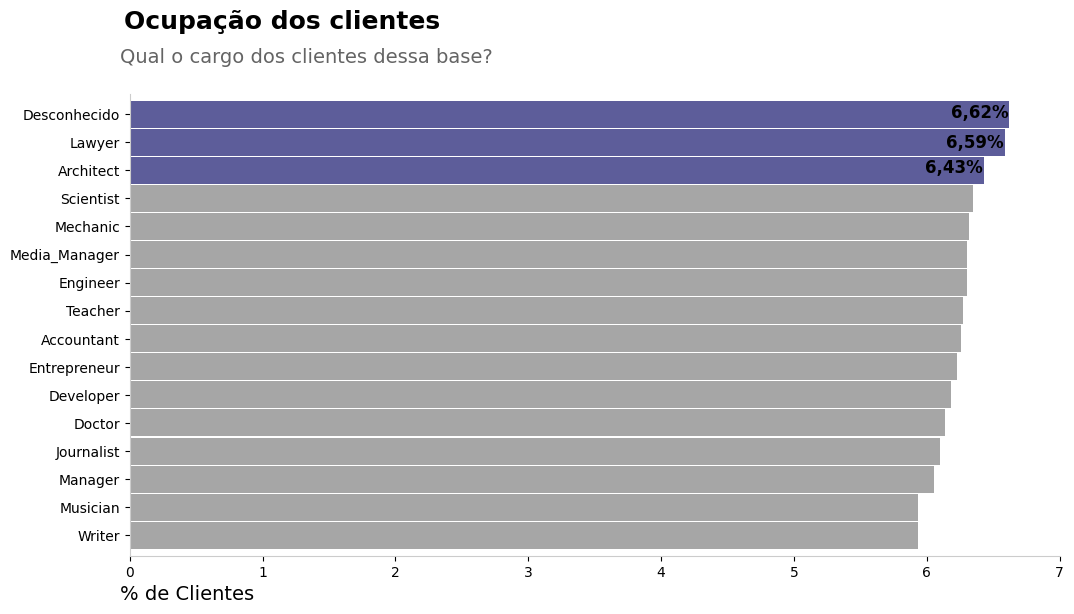

In [21]:
suptitle = 'Ocupação dos clientes'
title = 'Qual o cargo dos clientes dessa base?'

colors=['#808080']*13+['#191970']*3

creditScore = round(df['Occupation'].value_counts(normalize=True) * 100, 2)
creditScore = creditScore.sort_values(ascending=False)
creditScore = creditScore[::-1]

ax = creditScore.plot.barh(width=0.96,
                      alpha=0.7,
                      figsize=(12, 6),
                      rot=False,
                      color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#ccc')
ax.spines['left'].set_color('#ccc')

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlabel('% de Clientes', fontsize=14, horizontalalignment='left', x=-0.01)
plt.text(6.4, 14.86, '6,62%', fontsize=12, weight='bold', horizontalalignment='center')
plt.text(6.36, 13.79, '6,59%', fontsize=12, weight='bold', horizontalalignment='center')
plt.text(6.2, 12.9, '6,43%', fontsize=12, weight='bold', horizontalalignment='center')
plt.xlim(0, 7)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Pelo gráfico percebemos uma grande diversidade de profissionais nessa base, sem uma ocupação dominante. A presença de advogados e arquitetos é ligeiramente maior e temos uma presença significativa de pessoas que, possivelmente, não informaram seus cargos.</font></p>

### Análise do comportmento de pagamento

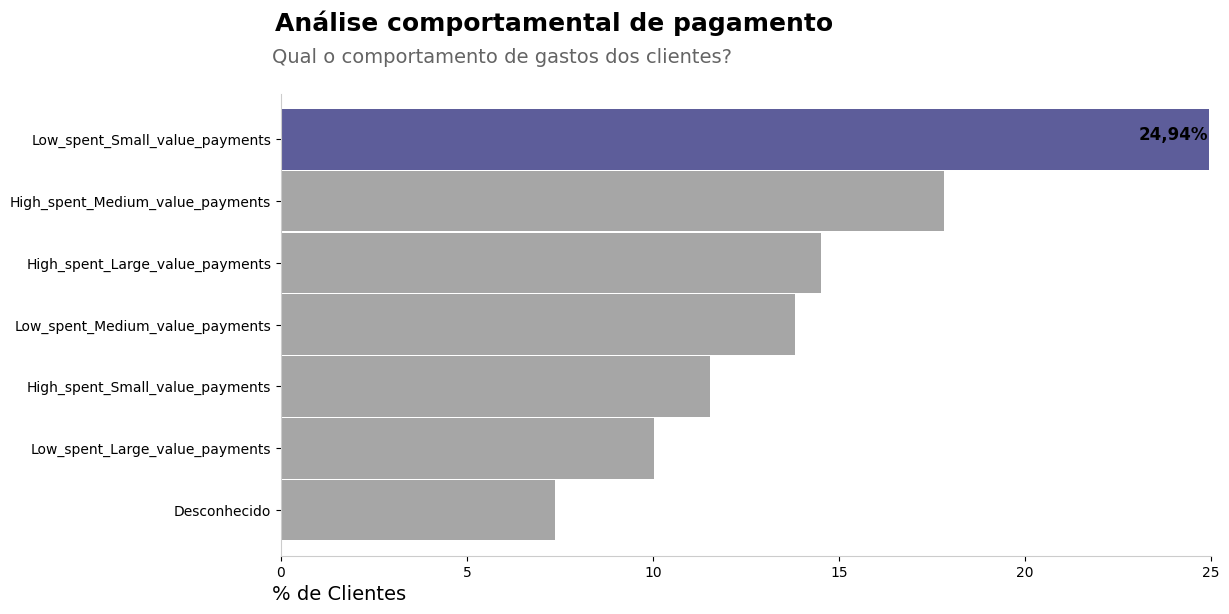

In [22]:
suptitle = 'Análise comportamental de pagamento'
title = 'Qual o comportamento de gastos dos clientes?'

colors=['#808080']*6+['#191970']

creditScore = df['Payment_Behaviour'].value_counts(normalize=True) * 100
creditScore = creditScore.sort_values(ascending=False)
creditScore = creditScore[::-1]

ax = creditScore.plot.barh(width=0.979, alpha=0.7, figsize=(12, 6), rot=False, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#ccc')
ax.spines['left'].set_color('#ccc')

plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.text(24, 6., '24,94%', fontsize=12, weight='bold', horizontalalignment='center')
plt.xlabel('% de Clientes', fontsize=14, horizontalalignment='left', x=-0.01)
plt.xlim(0, 25)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>O gráfico indica que a maiorias dos clientes têm um padrão de gastos baixo, principalmente em transações de pequeno valor. Podemos ver também que existe padrões de gastos distintos e também faltantes, o que sugere uma notável variação de comportamentos.</font></p>

### Correlação entre as variáveis categóricas

> Coeficiente de contingência Cramér avalia a força da associação entre duas variáveis categóricas em uma tabela de contingência. Ele varia de 0 a 1, onde 0 indica nenhuma associação e 1 indica uma associação total.

In [23]:
def calculateCramersVCoefficient(columnX: pd.Series, columnY: pd.Series) -> float:
    """
        Método responsável por calcular o coeficiente de Cramér para as variáveis categóricas
    """
    confusionMatrix = pd.crosstab(columnX, columnY)
    
    numberOfObservations = confusionMatrix.sum().sum()
    rows, columns = confusionMatrix.shape
    
    chi2, _, _, _ = chi2_contingency(confusionMatrix)
    phi2 = chi2 / numberOfObservations

    phi2corr = max(0, phi2 - ((columns-1)*(rows-1))/(numberOfObservations-1))
    rcorr = rows - ((rows-1)**2)/(numberOfObservations-1)
    kcorr = columns - ((columns-1)**2)/(numberOfObservations-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical = df[df.select_dtypes(include='O').columns]
correlation_matrix = pd.DataFrame(index=categorical.columns, columns=categorical.columns)

for i in categorical.columns:
    for j in categorical.columns:
        if i != j:
            correlation_matrix.loc[i, j] = calculateCramersVCoefficient(categorical[i], categorical[j])

correlation_matrix = correlation_matrix.fillna(1)
correlation_matrix.round(2)

,Occupation,Changed_Credit_Limit,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,Credit-Builder Loan,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Auto Loan,Personal Loan,Payday Loan,Student Loan
Occupation,1.00,0.00,0.00,0.00,0.02,0.03,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
Changed_Credit_Limit,0.00,1.00,0.04,0.05,0.02,0.03,0.03,0.00,0.00,0.01,0.01,0.00,0.01,0.00
Credit_Mix,0.00,0.04,1.00,0.49,0.06,0.49,0.24,0.22,0.23,0.23,0.23,0.23,0.22,0.22
Payment_of_Min_Amount,0.00,0.05,0.49,1.00,0.08,0.36,0.20,0.19,0.19,0.20,0.19,0.19,0.20,0.19
Payment_Behaviour,0.02,0.02,0.06,0.08,1.00,0.06,0.03,0.04,0.04,0.04,0.03,0.06,0.05,0.02
Credit_Score,0.03,0.03,0.49,0.36,0.06,1.00,0.16,0.15,0.16,0.15,0.17,0.16,0.16,0.15
Credit-Builder Loan,0.00,0.03,0.24,0.20,0.03,0.16,1.00,0.07,0.08,0.10,0.09,0.08,0.07,0.07
Debt Consolidation Loan,0.00,0.00,0.22,0.19,0.04,0.15,0.07,1.00,0.07,0.08,0.08,0.08,0.08,0.05
Mortgage Loan,0.03,0.00,0.23,0.19,0.04,0.16,0.08,0.07,1.00,0.08,0.07,0.09,0.07,0.07
Home Equity Loan,0.00,0.01,0.23,0.20,0.04,0.15,0.10,0.08,0.08,1.00,0.07,0.09,0.08,0.07


<p style='text-align: justify;'><font size=3.>As variáveis ocupação e alteração no limite de crédito parecem ter uma associação fraca próximo de zero com a maioria das outras variáveis. A combinação de diferentes tipos de contas de crédito mostra associações moderadas com as variáveis pagamento mínimo, pontuação de crédito e os tipos de empréstimos. A variável de pagamento mínimo e a de pontuação de crédito se associam moderadamente com a combinação de diferentes tipos de contas. Percebemos também que existem associações ligeiramente moderadas entre alguns tipos específicos de empréstimos</font></p>

### Correlação entre as variáveis numéricas

In [24]:
df.corr()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Month
Annual_Income,1.000000,0.017958,-0.003485,0.017235,0.003378,-0.005300,-0.004333,-0.007537,-0.008812,0.006197,0.021312,-0.001986,0.025027,0.013277,-0.006439
Monthly_Inhand_Salary,0.017958,1.000000,0.002402,-0.007670,0.003131,-0.016428,-0.219237,-0.002343,-0.008694,-0.233586,0.165788,0.006970,0.503169,0.620626,0.220709
Num_Bank_Accounts,-0.003485,0.002402,1.000000,0.001291,-0.007439,-0.009038,0.002887,0.003996,-0.010745,0.013928,0.003703,-0.008361,0.013601,-0.006342,0.000022
Num_Credit_Card,0.017235,-0.007670,0.001291,1.000000,-0.010462,-0.011139,-0.003639,-0.007323,0.001846,0.004112,0.002379,0.001461,-0.008261,0.006062,0.007571
Interest_Rate,0.003378,0.003131,-0.007439,-0.010462,1.000000,0.008967,0.013818,-0.010241,-0.008849,0.006668,0.012523,-0.007159,-0.001909,0.014301,-0.005712
Num_of_Loan,-0.005300,-0.016428,-0.009038,-0.011139,0.008967,1.000000,0.007686,0.036889,0.014116,0.019827,0.002805,-0.010018,-0.022463,-0.012259,-0.018230
Delay_from_due_date,-0.004333,-0.219237,0.002887,-0.003639,0.013818,0.007686,1.000000,0.013025,-0.006341,0.572461,-0.069811,-0.013634,-0.147098,-0.278331,-0.469424
Num_of_Delayed_Payment,-0.007537,-0.002343,0.003996,-0.007323,-0.010241,0.036889,0.013025,1.000000,0.005836,0.005566,0.005765,0.001078,-0.003445,0.000770,0.001492
Num_Credit_Inquiries,-0.008812,-0.008694,-0.010745,0.001846,-0.008849,0.014116,-0.006341,0.005836,1.000000,0.020579,0.002653,0.005594,-0.008280,-0.001821,-0.005414
Outstanding_Debt,0.006197,-0.233586,0.013928,0.004112,0.006668,0.019827,0.572461,0.005566,0.020579,1.000000,-0.080925,-0.016890,-0.156530,-0.314467,-0.594717


<p style='text-align: justify;'><font size=3.>O salário do cliente tem uma correlação forte com o valor investido mensalmente e o saldo nas contas. Também vemos uma correlação ligeiramente moderada positiva com o histórico de meses e moderada negativa com o valor de dívida pendente. O período de atraso nos pagamentos tem uma correlação moderada positiva com o valor da dívida pendente e vemos também que essa dívida também está associada, de forma levemente moderada, ao saldo mensal nas contas. É possível notar uma correlação negativa moderada do histórico mensal do cliente com períodos de atrasos e, mais forte, com o valor da dívida pendente.</font></p>

### Modelagem

#### Balanceamento das classes

> Para evitar um modelo tendencioso em relação à classe majoritária, será usado uma amostragem aleatória simples para equilibrar a base

In [25]:
df = df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

min_class_count = df['Credit_Score'].value_counts()[-1]
sampled = df.groupby('Credit_Score').apply(lambda x : x.sample(n=min_class_count, replace=False)).reset_index(drop=True)
sampled['Credit_Score'].value_counts()

Good        1975
Poor        1975
Standard    1975
Name: Credit_Score, dtype: int64

#### Encoder das labels

> Essa técnica será usada para converter as variáveis categóricas em números inteiros, tornando-as adequadas para serem usadas em algoritmos

In [26]:
X = sampled.drop(['Credit_Score'], axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(sampled['Credit_Score'])

#### Pipeline de pré-processamento

> Para recursos numéricos, usamos o StandardScaler para garantir que eles tenham uma escala padrão e para recursos categóricos, aplicamos OneHotEncoder para transformá-los em representações binárias

In [27]:
numericTransformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoricalTransformer = Pipeline(steps=[
    ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numericTransformer, X.select_dtypes(include='number').columns),
        ('categorical', categoricalTransformer, X.select_dtypes(include='O').columns)
    ])

#### Seleção de modelos: svm ou boosting

> A árvore de decisão foi escolhida por ser simples e lidar bem com problemas de classificação

In [29]:
result = {'classificador': [], 'acuraciaMedia': [], 'desvioPadrao': []}

fullPipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', None)])
baseClassifier = DecisionTreeClassifier(max_depth=1)

classifiers = [
    SVC(),
    AdaBoostClassifier(baseClassifier)
]

for classifier in classifiers:
    fullPipeline.set_params(classifier=classifier)
    scores = cross_val_score(fullPipeline, X, y, cv=5)

    result['classificador'].append(classifier.__class__.__name__)
    result['acuraciaMedia'].append(scores.mean().round(3))
    result['desvioPadrao'].append(scores.std().round(3))

pd.DataFrame(result).sort_values(by='acuraciaMedia', ascending=False)

,classificador,acuraciaMedia,desvioPadrao
0,SVC,0.766,0.012
1,AdaBoostClassifier,0.717,0.031


<p style='text-align: justify;'><font size=3.>Entre os modelos avaliados, o SVC foi o que apresentou a acurácia média mais alta com um desvio padrão relativamente baixo, o que indica uma maior consistência e menor variabilidade entre as diferentes execuções do modelo. Sendo assim, será esse o modelo escolhido para essa tarefa.</font></p>

#### Seleção de hiperparâmetros

> GridSearchCV foi escolhido para essa etapa por ser uma técnica famosa e fácil de usar para automatizar busca pelos melhores hiperparâmetros. Os valores foram escolhidos de forma aleatória com base no que já vi no decorrer dos estudos.

In [ ]:
paramGrid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': [1, 0.1, 0.001, 0.0001],
}

fullPipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

gridSearch = GridSearchCV(fullPipeline, paramGrid, cv=5, scoring='accuracy')
gridSearch.fit(X, y)

print(f'Melhor modelo: {gridSearch.best_params_}')
print(f'Melhor acurácia: {gridSearch.best_score_}')

#### Divisão dos dados em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=509, stratify=y)
print(f'Treino: {X_train.shape[0]}')
print(f'Teste: {X_test.shape[0]}')

#### Treinamento modelo final

In [ ]:
fullPipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

fullPipeline.fit(X_train, y_train)
y_pred = fullPipeline.predict(X_test)

#### Validação

In [ ]:
classification_report(y_test, y_pred, target_names=label_encoder.classes_.tolist())

#### Matriz de confusão

In [ ]:
np.set_printoptions(precision=2)
fig, ax = plt.subplots(figsize=(8, 4))
disp = ConfusionMatrixDisplay.from_estimator(
        fullPipeline,
        X_test,
        y_test,
        display_labels=label_encoder.classes_.tolist(),
        cmap=plt.cm.afmhot_r,
        normalize='true',
        xticks_rotation=None
)
plt.show()

## Aprendizado não supervisionado: segmentação de clientes

> Objetivo: extrair comportamentos e padrões destes dados e fazer recomendações

### Dicionário dos dados

| Campos                 | Descrição                                                                                      |
|------------------------|------------------------------------------------------------------------------------------------|
| Customer ID            | Identificador exclusivo                                                                       |
| Age                    | Idade do cliente                                                                              |
| Gender                 | Sexo biológico do cliente                                                                     |
| Item Purchased         | O produto ou item específico selecionado pelo cliente durante a transação                       |
| Category               | Classificação ampla ou grupo ao qual pertence o item comprado                                   |
| Purchase Amount (USD) | Valor monetário da transação, indicado em dólares dos EUA                                       |
| Location               | Localização geográfica onde a compra foi feita                                                  |
| Size                   | Especificação de tamanho (se aplicável) do item adquirido                                       |
| Color                  | Escolha de cor associada ao item adquirido                                                      |
| Season                 | Relevância sazonal do item comprado                                                             |
| Review Rating          | Avaliação fornecida pelo cliente em relação à sua satisfação com o item adquirido               |
| Subscription Status    | Indica se o cliente optou por um serviço de assinatura                                         |
| Shipping Type          | Método utilizado para entregar o item adquirido                                                 |
| Discount Applied       | Indica se algum desconto promocional foi aplicado à compra                                      |
| Promo Code Used        | Indica se um código promocional ou cupom foi utilizado durante a transação                      |
| Previous Purchases     | Informações sobre a quantidade ou frequência de compras anteriores realizadas pelo cliente      |
| Payment Method         | Especifica o modo de pagamento utilizado pelo cliente                                           |
| Frequency of Purchases  | Indica a frequência com que o cliente se envolve em atividades de compra                         |


### Carrega o dado

In [ ]:
df_clientes = pd.read_csv('data/shopping_behavior_updated.csv')
print(f'Linhas: {df_clientes.shape[0]} | Colunas: {df_clientes.shape[1]}')
df_clientes.head(1)

### Informação dataset

In [ ]:
df_clientes.info()

### Valores nulos

> A base não apresentou valores nulos e nem a necessidade de pré-processamento dos dados.

In [ ]:
df_clientes.stb.missing()

### Perfil médio dos clientes

In [ ]:
df_clientes.describe().round(2)

<p style='text-align: justify;'><font size=3.>A base de clientes tem uma ampla faixa etária, com a idade variando de 18 a 70 anos, sendo a idade média de aproximadamente 44 anos, com uma variação de 15 anos. Os clientes constumam comprar, em média, \$ 59,76 dólares, sendo o valor mínimo de \$ 20,00 dólares. A média da avaliação de 3,75 indica uma satisfação moderada com baixa variação. Em relação ao número de compras, temos clientes que compraram apenas 1 vez e outros que compraram até 50 vezes, sugerindo a existência de diferentes segmentos de clientes</font></p>

In [ ]:
df_clientes.describe(include='O')

<p style='text-align: justify;'><font size=3.>Os clientes são, em sua maioria, homens nessa base de dados. O item mais comprado foi blusa que pertence à categoria de roupas. Montana é o estado americano mais frequente, o tamanho de roupas mais comprados foi M e a cor preferida foi Oliva. A época de compra mais recorrente foi na primavera, a maioria das compras foi com frete grátis, boa parte dos clientes não possui assinatura, não utiliza descontos ou códigos promocionais e utiliza o método de pagamento PayPal. A maioria compra a cada 3 meses.</font></p>

### Distribuição da idade

In [ ]:
suptitle = 'Histograma da idade dos clientes'
title = 'Análise da distribuição para a variável idade'


ax = sns.distplot(df_clientes['Age'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.779)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)

plt.axvline(x=44.07, color='r', linestyle='dashed', linewidth=2, label='Média')
plt.text(46.5, 0.025, 'média', fontsize=10, weight='bold', horizontalalignment='center')
plt.axvline(x=44.00, color='g', linestyle='dashed', linewidth=2, label='Mediana')
plt.text(41, 0.025, 'mediana', fontsize=10, weight='bold', horizontalalignment='center')

plt.xlim(0, 80)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.show()

<p style='text-align: justify;'><font size=3.>Podemos ver que a idade dos clientes possui uma grande variação entre 18 e 70 anos. O valor da média e mediana são bem próximos o que geralmente significa que a distribuição é aproximadamente simétrica, se aproximando da distribuição normal. Isso indica que os valores não tendem a se concentrar em um dos lados da distribuição.</font></p>